In [2]:
!pip install -q efficientnet >> /dev/null # Loading efficient net with pretrained weights from image net

In [3]:
from kaggle_datasets import KaggleDatasets

import tensorflow as tf, re, math
import tensorflow.keras.backend as K
import efficientnet.tfkeras as efn

import matplotlib.pyplot as plt
import numpy as np
from glob import glob
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score

In [4]:
FOLDS = 5 # K-folds
IMG_SIZES = [[256,256]] * FOLDS

BATCH_SIZES = [32] * FOLDS
EPOCHS = [15] * FOLDS

DEVICE = 'TPU'
SEED = 42
VERBOSE = 0 # VERBOSE=0 for silent, VERBOSE=1 for interactive, VERBOSE=2 for commit

# prepare images 
AUGMENT = False # Augmentation is not performed and corresponding dropout is disabled
TRANSFORM = False # Since data augmentation is to-do
sat  = (0.7, 1.3)
cont = (0.8, 1.2)
bri  =  0.1

# WHICH EFFICIENTNET B? TO USE
EFF_NETS = [6]*FOLDS

# USE VERBOSE=0 for silent, VERBOSE=1 for interactive, VERBOSE=2 for commit
VERBOSE      = 0
DISPLAY_PLOT = True

# WEIGHTS FOR FOLD MODELS WHEN PREDICTING TEST
WGTS = [1/FOLDS]*FOLDS # Not sure

# TEST TIME AUGMENTATION STEPS
TTA = 11 #Not sure why 11

ClusterResolvers are a way for TensorFlow to communicate with various cluster management systems (e.g. GCE, AWS, etc...) and gives TensorFlow necessary information to set up distributed training. https://www.tensorflow.org/api_docs/python/tf/distribute/cluster_resolver/ClusterResolver

Strategy for distributed training: tpustrategy = "synchronous distributed training" https://www.tensorflow.org/guide/distributed_training#tpustrategy

The tf.data API provides the tf.data.Dataset.prefetch transformation. It can be used to decouple the time when data is produced from the time when data is consumed. In particular, the transformation uses a background thread and an internal buffer to prefetch elements from the input dataset ahead of the time they are requested. The number of elements to prefetch should be equal to (or possibly greater than) the number of batches consumed by a single training step. You could either manually tune this value, or set it to tf.data.AUTOTUNE, which will prompt the tf.data runtime to tune the value dynamically at runtime. https://www.tensorflow.org/guide/data_performance

Custom training : Replicas


In [5]:
if DEVICE == "TPU":
    print("connecting to TPU")
    try:
        tpu = tf.distribute.cluster_resolver.TPUClusterResolver() #abstract methods
    except ValueError:
        print("Could not connect to TPU")
        tpu = None
    if tpu:
        try:
            print("initializing TPU")
            tf.config.experimental_connect_to_cluster(tpu)
            tf.tpu.experimental.initialize_tpu_system(tpu) # initialize the tpu devices
            strategy= tf.distribute.experimental.TPUStrategy(tpu) # single client strategy
            # program is expected to run on only one task, that is this notebook
            print("TPU initialized")
        except:
            print("failed to initialize TPU")
    else:
        DEVICE = "GPU"
if DEVICE != "TPU":
    print("Num GPUs available:", len(tf.config.experimental.list_physical_devices('GPU')))

AUTO = tf.data.experimental.AUTOTUNE # Module is tf.data.experimental
REPLICAS = strategy.num_replicas_in_sync #num_replicas_in_sync is the number of TPU cores, here we use 8 of them
print(f'REPLICAS: {REPLICAS}')

connecting to TPU
initializing TPU
TPU initialized
REPLICAS: 8


Hide user secret in Add-ons https://www.kaggle.com/product-feedback/114053

In [6]:
project="GCP_PROJECT_ID"
import sys
if "kaggle_secrets" in sys.modules:
    from kaggle_secrets import UserSecretsClient
    UserSecretsClient().set_gcloud_credentials(project)
    user_credential = UserSecretsClient().get_gcloud_credential()
#Set the credentials
UserSecretsClient().set_tensorflow_credential(user_credential)
# UserSecretsClient().get_gcloud_credential()

Activate GCP and CloudTPU as shown in https://www.kaggle.com/nitric/google-cloud-project-setup-instructions


In [7]:
GCS_PATH = [None]*FOLDS
for i,k in enumerate(IMG_SIZES):
    GCS_PATH[i] = KaggleDatasets().get_gcs_path('seti%ix%itfrecdataset'%(k[0],k[1]))
files_train = np.sort(np.array(tf.io.gfile.glob(GCS_PATH[0] + '/train*.tfrec')))
files_test  = np.sort(np.array(tf.io.gfile.glob(GCS_PATH[0]  + '/test*.tfrec')))
num_train_files = len(files_train)
num_test_files  = len(files_test)
print('train_files:',num_train_files)
print('test_files:',num_test_files)

train_files: 20
test_files: 10


# Data Augmentation: to do

# Reading TF record files

In [8]:
def read_labeled_tfrecord(example):
    # reads training data
    # parsing the features in example , in corresponding format
    # fixedLenFeature is a class with attributes shape, dtype and default value
    # https://www.tensorflow.org/api_docs/python/tf/io/FixedLenFeature?hl=fr#attributes
    
    tfrec_format = {
        'image'      : tf.io.FixedLenFeature([],tf.string),
        'image_id'   : tf.io.FixedLenFeature([],tf.string),
        'target'     : tf.io.FixedLenFeature([],tf.int64)
    }
    example =  tf.io.parse_single_example(example, tfrec_format)
    return example['image'],example['target']

def read_unlabeled_tfrecord(example, return_image_id):
    # reads test data
    tfrec_format = {
        'image'      : tf.io.FixedLenFeature([],tf.string),
        'image_id'   : tf.io.FixedLenFeature([],tf.string)}
    example =  tf.io.parse_single_example(example, tfrec_format)
    return example['image'], example['image_id'] if return_image_id else 0
  

In [9]:
# Preparing the image data

def prepare_image(img, augment= True, dim = IMG_SIZES[0]):
    img = tf.image.decode_png(img, channels =3) # decode a PNG-encoded image to uint8 or uint16 tensor
    # channel 3 implies RGB image
    img = tf.cast(img,tf.float32)
    img = img/255.0
    # normalising the values in the image to be in range (0,1)
    
    if augment:
        img = transform(img, DIM=dim) if TRANSFORM else img # data augmentation
        img = tf.image.random_flip_left_right(img)
        img = tf.image.random_saturation(img, sat[0], sat[1])
        img = tf.image.random_contrast(img, cont[0], cont[1])
        img = tf.image.random_brightness(img, bri)
    
    img = tf.reshape(img, [*dim, 3])
    
    return img

# Getting the dataset and preparing it 


tf.data.TFRecordDataset:

https://www.tensorflow.org/api_docs/python/tf/data/TFRecordDataset

*     A Dataset comprising records from one or more TFRecord files
*     This dataset loads TFRecords from the files as bytes, exactly as they were written
*     TFRecordDataset does not do any parsing or decoding on its own
*     Parsing and decoding can be done by applying Dataset.map transformations after the TFRecordDataset

num_parallel_reads:

*     A tf.int64 scalar representing the number of files to read in parallel
*     If greater than one, the records of files read in parallel are outputted in an interleaved order
*     If your input pipeline is I/O bottlenecked, consider setting this parameter to a value greater than one to parallelize the I/O. If None, files will be read sequentially.

Cache:

*     Caches the elements in this dataset.
*     The first time the dataset is iterated over, its elements will be cached either in the specified file or in memory. Subsequent iterations will use the cached data

Options: https://www.tensorflow.org/api_docs/python/tf/data/Options

*     A tf.data.Options object can be, for instance, used to control which static optimizations to apply to the input pipeline graph or whether to use performance modeling to dynamically tune the parallelism of operations such as tf.data.Dataset.map or tf.data.Dataset.interleave.
*     The options are set for the entire dataset and are carried over to datasets created through tf.data transformations.
*     The options can be set by constructing an Options object and using the tf.data.Dataset.with_options(options) transformation, which returns a dataset with the options set.

Shuffle:

*     Randomly shuffles the elements of this dataset.
*     This dataset fills a buffer with buffer_size elements, then randomly samples elements from this buffer, replacing the selected elements with new elements. For perfect shuffling, a buffer size greater than or equal to the full size of the dataset is required.
*     For instance, if your dataset contains 10,000 elements but buffer_size is set to 1,000, then shuffle will initially select a random element from only the first 1,000 elements in the buffer. Once an element is selected, its space in the buffer is replaced by the next (i.e. 1,001-st) element, maintaining the 1,000 element buffer.

Repeat:

* Default repeat of the dataset indefinitely

Batch:

*     Combines consecutive elements of this dataset into batches.
* (global batch size = batchsize_per_replica x replicas ) https://www.tensorflow.org/tutorials/distribute/custom_training#define_the_loss_function

Prefetch:

*     Creates a Dataset that prefetches elements from this dataset.
*     Most dataset input pipelines should end with a call to prefetch. This allows later elements to be prepared while the current element is being processed. This often improves latency and throughput, at the cost of using additional memory to store prefetched elements.

Additional info:

Cardinality:

*     Returns the cardinality of the dataset, if known.
*     cardinality may return tf.data.INFINITE_CARDINALITY if the dataset contains an infinite number of elements or tf.data.UNKNOWN_CARDINALITY if the analysis fails to determine the number of elements in the dataset (e.g. when the dataset source is a file).


In [10]:
def get_dataset(files, augment = False, shuffle = False, repeat = False,
               labeled = True, return_image_ids = True, batch_size = 16, dim = IMG_SIZES[0]):
    
    # many tfrecord files are read in parallel
    ds= tf.data.TFRecordDataset(files, num_parallel_reads = AUTO)
     
    # cache the data for next sequential use
    ds =ds.cache()
    
    if repeat:
        # dataset is repeated indefinitely
        ds=ds.repeat()
    
    if shuffle:
        # randomly shuffled, shuffle buffer size greater than length of dataset
        ds = ds.shuffle(1024*2, seed = SEED)
        opt = tf.data.Options()
        opt.experimental_deterministic = False
        ds = ds.with_options(opt)
    
    if labeled:
        ds = ds.map(read_labeled_tfrecord, num_parallel_calls = AUTO)
    else:
        ds = ds.map(lambda example: read_unlabeled_tfrecord(example, return_image_ids),
                   num_parallel_calls = AUTO)
    ds = ds.map(lambda img, imgid_or_label: (prepare_image(img, augment = augment, dim =dim),imgid_or_label),
                num_parallel_calls = AUTO)
    
    #if labeled and augment: 
    # to add when data augmentation added
     
    ds = ds.batch(batch_size * REPLICAS) # counting total batch size across 8 cores, batch size init is 32, 256 (32*8) total size
    ds =ds.prefetch(AUTO)
    return ds

# EfficientNet Model

In [11]:
EFNS = [efn.EfficientNetB0, efn.EfficientNetB1, efn.EfficientNetB2, efn.EfficientNetB3,
       efn.EfficientNetB4, efn.EfficientNetB5, efn.EfficientNetB6 ]

def build_model(dim=IMG_SIZES[0], ef =0):
    inp = tf.keras.layers.Input(shape= (*dim, 3)) # input shape
    base = EFNS[ef](input_shape=(*dim,3), weights='imagenet', include_top = False) 
    # model base with include_top = False meaning that the final dense layer is not selected 
    x = base(inp)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dense(32, activation = 'relu')(x)
    x = tf.keras.layers.Dense(1, activation = 'sigmoid')(x)
    
    # complete model
    model = tf.keras.Model(inputs = inp, outputs =x)
    
    # model parameters
    opt = tf.keras.optimizers.Adam(learning_rate=0.01)
    loss = tf.keras.losses.BinaryCrossentropy(label_smoothing =0.01)
    
    # model compile
    model.compile(optimizer=opt,loss=loss,metrics =['AUC'])
    
    return model

# Learning rate scheduler

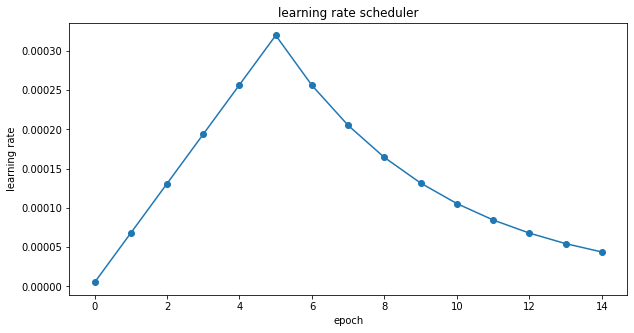

In [12]:
def get_lr_callback(batch_size= 8, plot=False):
    
    lr_start = 0.000005
    lr_max = 0.00000125* REPLICAS * batch_size
    lr_min = 0.000001
    lr_ramp_ep = 5
    lr_sus_ep = 0
    lr_decay = 0.8
    
    def lrfn(epoch):
        if epoch < lr_ramp_ep:
            lr = (lr_max - lr_start) / lr_ramp_ep * epoch + lr_start
        elif epoch < lr_ramp_ep + lr_sus_ep:
            lr = lr_max
        else:
            lr = (lr_max - lr_min) * lr_decay **(epoch - lr_ramp_ep - lr_sus_ep) + lr_min
        return lr
    
    if plot:
        plt.figure(figsize =(10,5))
        plt.plot(np.arange(EPOCHS[0]), [lrfn(epoch) for epoch in np.arange(EPOCHS[0])], marker = 'o')
        plt.xlabel('epoch')
        plt.ylabel('learning rate')
        plt.title('learning rate scheduler')
        plt.show()
    
    lr_callback = tf.keras.callbacks.LearningRateScheduler(lrfn,verbose = False)
    return lr_callback
                     
_ = get_lr_callback(BATCH_SIZES[0], plot = True)

# Putting it together

with strategy.scope():
https://www.tensorflow.org/guide/tpu

*     Keras model creation needs to be inside strategy.scope, so the variables can be created on each TPU device. Other parts of the code are not necessary to be inside the strategy scope.

tf.keras.callbacks.ModelCheckpoint
https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ModelCheckpoint

*     Callback to save the Keras model or model weights at some frequency.

tf.keras.callbacks.LearningRateScheduler
https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/LearningRateScheduler

train-val-test split

*     stratified fold: train is split to train and validation, test remains same

Out of fold

*     oof data is that what is not seen in the training during k-fold

fit

*     train data is used , repeat as false

predict oof with tta

*     valid data with unlabeled info, repeat as true
*     get oof_tar and folds with valid and labeled info, repeat false
*     get oof_ids with valid and labeled false, repeat false

predict test with tta

*     test files, labeled false, repeat as true

TTA (Test time augmentation)
https://towardsdatascience.com/test-time-augmentation-tta-and-how-to-perform-it-with-keras-4ac19b67fb4d

*     augmenting the test data and averaging the prediction results



In [13]:
def count_data_items(fileids):
    n = [int(re.compile(r"-([0-9]*)\.").search(fileid).group(1)) 
         for fileid in fileids]
    return np.sum(n)

tpu initialized
#########################
#### FOLD 1
#### Image Size: (256, 256) | model: EfficientNetB6 | batch_size 256
#### Training: 48000 | Validation: 12000
165527552/165527152 [==============================] - 2s 0us/step
#########################
Training...
Loading best model...
Predicting OOF with TTA
Predicting Test with TTA...
#### FOLD 1 OOF AUC without TTA = 0.638, with TTA = 0.638


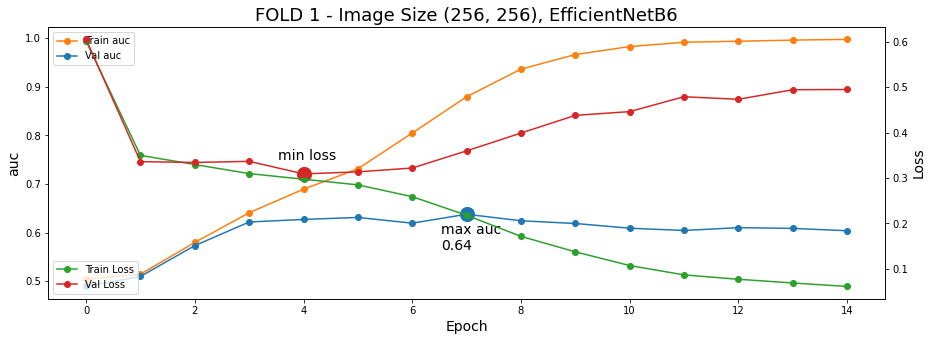

tpu initialized
#########################
#### FOLD 2
#### Image Size: (256, 256) | model: EfficientNetB6 | batch_size 256
#### Training: 48000 | Validation: 12000
#########################
Training...
Loading best model...
Predicting OOF with TTA
Predicting Test with TTA...
#### FOLD 2 OOF AUC without TTA = 0.635, with TTA = 0.635


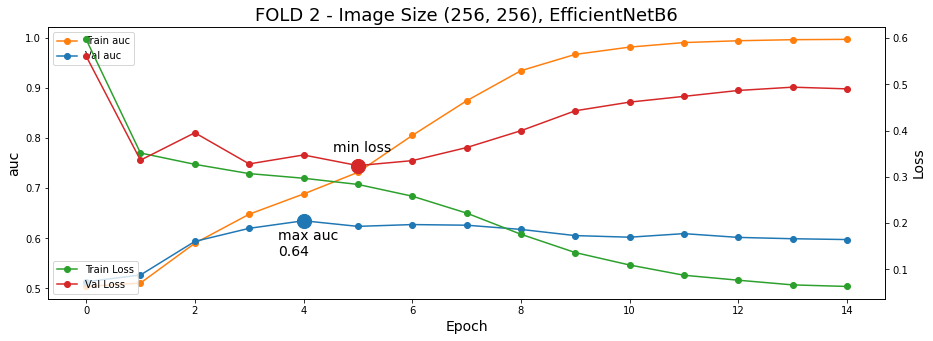

tpu initialized
#########################
#### FOLD 3
#### Image Size: (256, 256) | model: EfficientNetB6 | batch_size 256
#### Training: 48000 | Validation: 12000
#########################
Training...
Loading best model...
Predicting OOF with TTA
Predicting Test with TTA...
#### FOLD 3 OOF AUC without TTA = 0.624, with TTA = 0.625


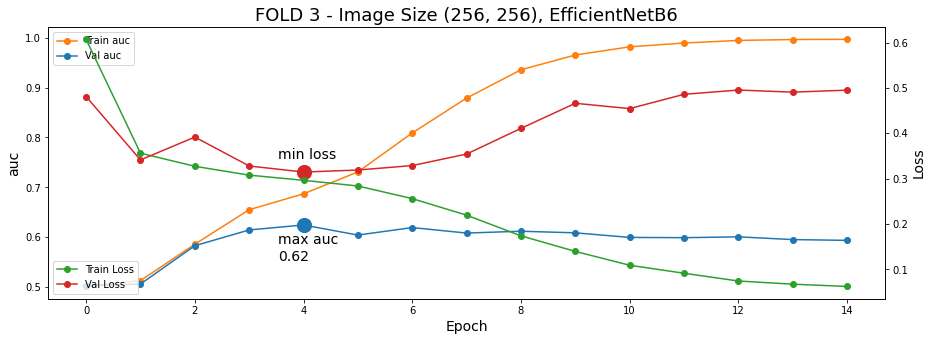

tpu initialized
#########################
#### FOLD 4
#### Image Size: (256, 256) | model: EfficientNetB6 | batch_size 256
#### Training: 48000 | Validation: 12000
#########################
Training...
Loading best model...
Predicting OOF with TTA
Predicting Test with TTA...
#### FOLD 4 OOF AUC without TTA = 0.621, with TTA = 0.621


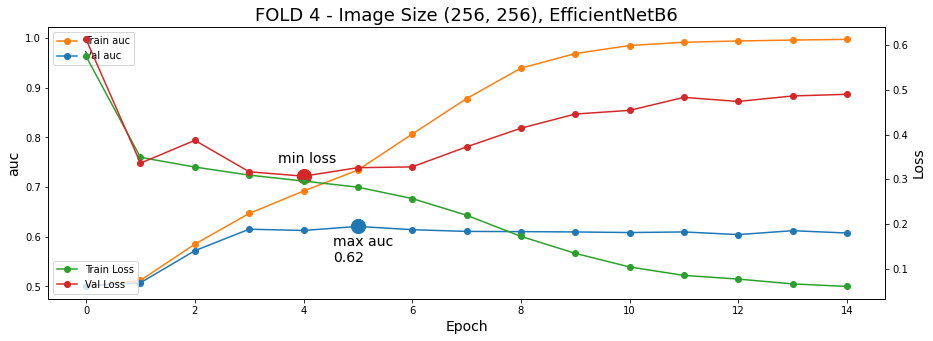

tpu initialized
#########################
#### FOLD 5
#### Image Size: (256, 256) | model: EfficientNetB6 | batch_size 256
#### Training: 48000 | Validation: 12000
#########################
Training...
Loading best model...
Predicting OOF with TTA
Predicting Test with TTA...
#### FOLD 5 OOF AUC without TTA = 0.627, with TTA = 0.626


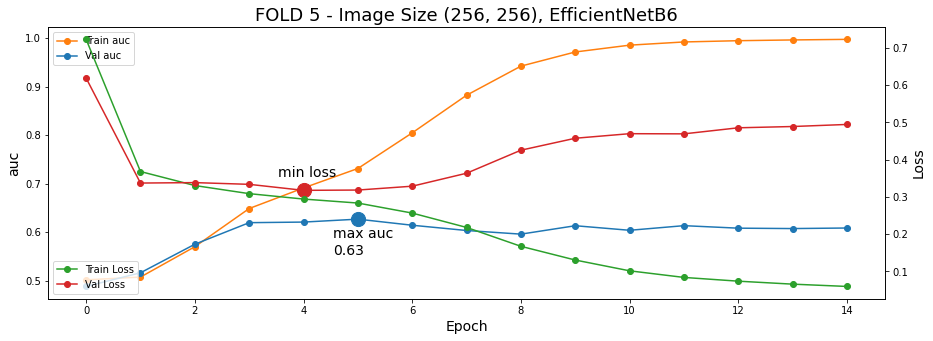

In [14]:
#init
skf = KFold(n_splits=FOLDS,shuffle=True,random_state=SEED)
# out of fold predictions, target , validation, F1 score, ids and folds
oof_pred = []; oof_tar = []; oof_val = []; oof_f1 = []; oof_ids = []; oof_folds = [] 
preds = np.zeros((count_data_items(files_test),1))

# each fold, modelling sequence
for fold, (idxT,idxV) in enumerate(skf.split(np.arange(num_train_files))):
    
    if DEVICE == 'TPU':
        if tpu: tf.tpu.experimental.initialize_tpu_system(tpu)
        print("tpu initialized")
    
    # Create train and validation subsets
    files_train = tf.io.gfile.glob([GCS_PATH[fold] + '/train%.2i*.tfrec'%x for x in idxT])
    np.random.shuffle(files_train)
    files_valid = tf.io.gfile.glob([GCS_PATH[fold] + '/train%.2i*.tfrec'%x for x in idxV])
    files_test = np.sort(np.array(tf.io.gfile.glob(GCS_PATH[fold] + '/test*.tfrec')))
    
    print('#'*25);
    print('#### FOLD', fold+1)
    print('#### Image Size: (%i, %i) | model: %s | batch_size %i'%
         (IMG_SIZES[fold][0], IMG_SIZES[fold][1], EFNS[EFF_NETS[fold]].__name__, BATCH_SIZES[fold]*REPLICAS))
    train_images = count_data_items(files_train)
    val_images = count_data_items(files_valid)
    print('#### Training: %i | Validation: %i'%(train_images,val_images))
    
    # Build model
    
    K.clear_session()
    with strategy.scope():
        model = build_model(dim = IMG_SIZES[fold], ef = EFF_NETS[fold])
    
    print('#'*25)
    
    # SAVE BEST MODEL EACH FOLD
    sv = tf.keras.callbacks.ModelCheckpoint('fold-%i.h5'%fold, monitor = 'val_auc',verbose = 0, save_best_only = True,
                                               save_weights_only = True, mode = 'max', save_freq = 'epoch')
    
     # TRAIN
    print('Training...')
    
    # Model fit arguments
    # callbacks -> model checkpoint to load best model and early stopping with learning rate?
    # steps_per_epoch -> when performing infinitely repeated dataset, this argument has to be specified
        # here training data is first split by batch size, then divided by replica , to know for each core
    # batch size: for each batch, model paramters are updated
    # for one epoch, model has one chance to go through all the training data atleast once
    # epochs-> number of epochs the model has to be trained
    
    history = model.fit(get_dataset(files_train, augment = AUGMENT, shuffle = True, repeat = True, dim= IMG_SIZES[fold],
                                   batch_size = BATCH_SIZES[fold]),
                        epochs = EPOCHS[fold], 
                        callbacks = [sv, get_lr_callback(BATCH_SIZES[fold])],
                        steps_per_epoch = count_data_items(files_train)/BATCH_SIZES[fold]//REPLICAS,
                        validation_data = get_dataset(files_valid, augment = False, shuffle=False, repeat=False, dim = IMG_SIZES[fold]),
                        verbose = VERBOSE)
    
    # Loading best model for inference
    print('Loading best model...')
    model.load_weights('fold-%i.h5'%fold)
    
    #PREDICT OOF USING TTA
    # Out of fold
    print('Predicting OOF with TTA')
    ds_valid = get_dataset(files_valid, labeled = False, return_image_ids = False, augment = AUGMENT,
                          repeat = True, shuffle= False, dim = IMG_SIZES[fold], batch_size = BATCH_SIZES[fold]*2)
    
    ct_valid = count_data_items(files_valid)
    STEPS = TTA* ct_valid/BATCH_SIZES[fold]/2/REPLICAS # why there is 2 here ?
    pred = model.predict(ds_valid, steps =STEPS, verbose = VERBOSE)[:TTA*ct_valid,]
    oof_pred.append(np.mean(pred.reshape((ct_valid,TTA), order = 'F'), axis=1))
    
    # GET OOF TARGETS AND idS
    ds_valid = get_dataset(files_valid, augment=False, repeat=False, dim=IMG_SIZES[fold],
            labeled=True, return_image_ids=True)
    oof_tar.append( np.array([target.numpy() for img, target in iter(ds_valid.unbatch())]) )
    oof_folds.append( np.ones_like(oof_tar[-1],dtype='int8')*fold )
    ds = get_dataset(files_valid, augment=False, repeat=False, dim=IMG_SIZES[fold],
                labeled=False, return_image_ids=True)
    oof_ids.append( np.array([img_id.numpy().decode("utf-8") for img, img_id in iter(ds.unbatch())]))
    
    # PREDICT TEST USING TTA
    print('Predicting Test with TTA...')
    ds_test = get_dataset(files_test,labeled=False,return_image_ids=False,augment=AUGMENT,
            repeat=True,shuffle=False,dim=IMG_SIZES[fold],batch_size=BATCH_SIZES[fold]*2)
    ct_test = count_data_items(files_test); 
    STEPS = TTA * ct_test/BATCH_SIZES[fold]/2/REPLICAS
    pred = model.predict(ds_test,steps=STEPS,verbose=VERBOSE)[:TTA*ct_test,] 
    preds[:,0] += np.mean(pred.reshape((ct_test,TTA),order='F'),axis=1) * WGTS[fold]
    
    # REPORT RESULTS
    auc = roc_auc_score(oof_tar[-1],oof_pred[-1])
    oof_val.append(np.max( history.history['val_auc'] ))
    print('#### FOLD %i OOF AUC without TTA = %.3f, with TTA = %.3f'%(fold+1,oof_val[-1],auc))
    
    # PLOT TRAINING
    if DISPLAY_PLOT:
        plt.figure(figsize=(15,5))
        plt.plot(np.arange(len(history.history['auc'])),history.history['auc'],'-o',label='Train auc',color='#ff7f0e')
        plt.plot(np.arange(len(history.history['auc'])),history.history['val_auc'],'-o',label='Val auc',color='#1f77b4')
        x = np.argmax( history.history['val_auc'] ); y = np.max( history.history['val_auc'] )
        xdist = plt.xlim()[1] - plt.xlim()[0]; ydist = plt.ylim()[1] - plt.ylim()[0]
        plt.scatter(x,y,s=200,color='#1f77b4'); plt.text(x-0.03*xdist,y-0.13*ydist,'max auc\n%.2f'%y,size=14)
        plt.ylabel('auc',size=14); plt.xlabel('Epoch',size=14)
        plt.legend(loc=2)
        plt2 = plt.gca().twinx()
        plt2.plot(np.arange(len(history.history['auc'])),history.history['loss'],'-o',label='Train Loss',color='#2ca02c')
        plt2.plot(np.arange(len(history.history['auc'])),history.history['val_loss'],'-o',label='Val Loss',color='#d62728')
        x = np.argmin( history.history['val_loss'] ); y = np.min( history.history['val_loss'] )
        ydist = plt.ylim()[1] - plt.ylim()[0]
        plt.scatter(x,y,s=200,color='#d62728'); plt.text(x-0.03*xdist,y+0.05*ydist,'min loss',size=14)
        plt.ylabel('Loss',size=14)
        plt.title('FOLD %i - Image Size (%i, %i), %s'%
                (fold+1,IMG_SIZES[fold][0],IMG_SIZES[fold][1],EFNS[EFF_NETS[fold]].__name__),size=18)
        plt.legend(loc=3)
        plt.savefig(f'fig{fold}.png')
        plt.show()
